[horizontal-voting-ensemble](https://machinelearningmastery.com/horizontal-voting-ensemble/)

In [24]:
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [26]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=0)

In [27]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.804


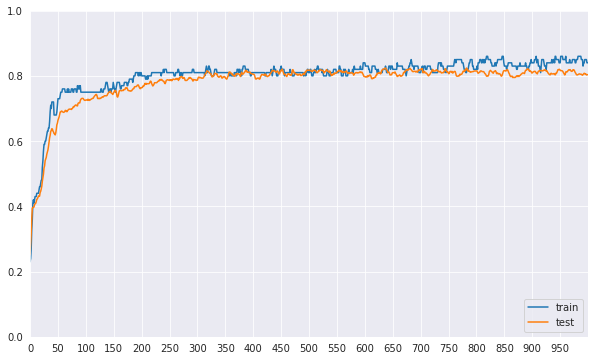

In [30]:
# learning curves of model accuracy
fig = pyplot.figure(figsize=(10, 6))
ax = pyplot.plot(history.history['acc'], label='train')
ax = pyplot.plot(history.history['val_acc'], label='test')
_ = pyplot.legend(loc='lower right')
_ = pyplot.xlim(0, 1000)
_ = pyplot.ylim(0, 1)
_ = pyplot.xticks(ticks=range(0,1000, 50))
sns.despine()

In [31]:
# save horizontal voting ensemble members during training
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# create directory for models
makedirs('models')
# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
    # fit model for a single epoch
    model.fit(trainX, trainy, epochs=1, verbose=0)
    # check if we should save the model
    if i >= n_save_after:
        model.save('models/model_' + str(i) + '.h5')

(100, 2) (1000, 2)


(100, 2) (1000, 2)
>loaded models/model_950.h5
>loaded models/model_951.h5
>loaded models/model_952.h5
>loaded models/model_953.h5
>loaded models/model_954.h5
>loaded models/model_955.h5
>loaded models/model_956.h5
>loaded models/model_957.h5
>loaded models/model_958.h5
>loaded models/model_959.h5
>loaded models/model_960.h5
>loaded models/model_961.h5
>loaded models/model_962.h5
>loaded models/model_963.h5
>loaded models/model_964.h5
>loaded models/model_965.h5
>loaded models/model_966.h5
>loaded models/model_967.h5
>loaded models/model_968.h5
>loaded models/model_969.h5
>loaded models/model_970.h5
>loaded models/model_971.h5
>loaded models/model_972.h5
>loaded models/model_973.h5
>loaded models/model_974.h5
>loaded models/model_975.h5
>loaded models/model_976.h5
>loaded models/model_977.h5
>loaded models/model_978.h5
>loaded models/model_979.h5
>loaded models/model_980.h5
>loaded models/model_981.h5
>loaded models/model_982.h5
>loaded models/model_983.h5
>loaded models/model_984.h5
>

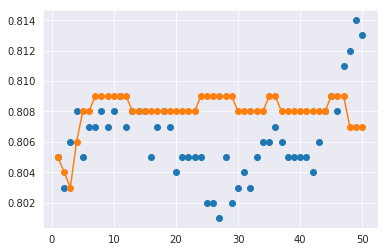

In [32]:
# load models and make predictions using a horizontal voting ensemble
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax


# load models from file
def load_all_models(n_start, n_end):
    all_models = list()
    for epoch in range(n_start, n_end):
        # define filename for this ensemble
        filename = 'models/model_' + str(epoch) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    # argmax across classes
    result = argmax(summed, axis=1)
    return result


# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members) + 1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)
    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i - 1].evaluate(testX, testy_enc, verbose=0)
    # summarize this step
    print(
        '> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members) + 1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()